<a href="https://colab.research.google.com/github/shimjaeman/PyTorch-Tutorials/blob/main/04_(Pytorch)Linear_model_california_housing_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# california housing prediction

## 데이터 확인 및 전처리



In [43]:
# 기본 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 호출 라이브러리
from sklearn.datasets import fetch_california_housing

# 전처리 라이브러리
from scipy.special import boxcox1p
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Pytorch 라이브러리
import torch
import torchvision
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision.transforms as transforms 
from tqdm import tqdm  

# colab drive 호출
from google.colab import drive

In [20]:
# distplot 함수 
def distplot_check (cols):
    cols_len = len(cols)
    if cols_len % 2 == 0 :
        row_size = (cols_len // 2)
    else : 
        row_size = (cols_len // 2) + 1

    fig, axes = plt.subplots(row_size, 2, figsize=(25, 15))
    plt.subplots_adjust(wspace=0.3,  hspace=0.7)
    sns.set_theme(style="white", context="talk")
    row, col = 0, 0

    for sca_col in cols: 
        df_sca = train_data[sca_col].values

        if col > 1:
            row += 1
            col = 0
            sns.displot(df_sca, ax=axes[row, col])
            axes[row, col].set_title(sca_col)
            col += 1

        else : 
            sns.displot(df_sca, ax=axes[row, col])
            axes[row, col].set_title(sca_col)
            col += 1      

In [21]:
# 비대칭 데이터 확인 
def skewed_check (date, col):
    skewness = date[col].apply(lambda x : x.skew()).sort_values(ascending=False)
    sk_df = pd.DataFrame(skewness, columns = ["skewness"])
    sk_df.sort_values(by="skewness", ascending=False)
    sk_df["skw"] = abs(sk_df["skewness"])
    sk_df = sk_df.sort_values(by="skw", ascending=False).drop("skewness", axis=1)
    skw_features = np.unique(sk_df[sk_df.skw > 0.5].index)
    return skw_features

> 변수 설명


  - longitude : 경도
  - latitude : 위도
  - housing_median_age : 주택 나이 (중앙값)
  - total_rooms : 전체 방 수
  - total_bedrooms : 전체 침실 수
  - population : 인구
  - households : 세대
  - median_income : 소득(중앙값)
  - median_house_value : 주택 가치(중앙값)
  - ocean_proximity : 바다 근접도

In [22]:
california = fetch_california_housing()
train= pd.DataFrame(california.data, columns=california.feature_names)
test = pd.DataFrame(california.target, columns=california.target_names)

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [24]:
train.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


In [25]:
train.isnull().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64

In [26]:
train_sk = skewed_check(train, train.columns)

In [27]:
# Box-Cox Transform
lam = 0.01
for col in train_sk:
  train[col] = boxcox1p(train[col], lam)

trans_skewness = train[train_sk].apply(lambda x : x.skew()).sort_values(ascending=False)
trans_sk_df = pd.DataFrame(trans_skewness, columns = ["skewness"])
trans_sk_df.sort_values(by="skewness", ascending=False)
trans_sk_df["skw"] = abs(trans_sk_df["skewness"])
trans_sk_df = trans_sk_df.sort_values(by="skw", ascending=False).drop("skewness", axis=1)
trans_sk_df

,skw
AveBedrms,9.065994
AveOccup,4.084940
AveRooms,1.433814
Population,0.985131
MedInc,0.237857


In [28]:
# 각 컬럼 스케일링 수행 
Scaler = MinMaxScaler()
train_data = Scaler.fit_transform(train)
train_df = pd.DataFrame(train_data, columns = train.columns)
train_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,0.769847,0.784314,0.331857,0.125819,0.471423,0.109217,0.567481,0.211155
1,0.768760,0.392157,0.309475,0.117966,0.693803,0.089453,0.565356,0.212151
2,0.718174,1.000000,0.366419,0.133140,0.518811,0.119126,0.564293,0.210159
3,0.625902,1.000000,0.295820,0.133084,0.531773,0.108900,0.564293,0.209163
4,0.492478,1.000000,0.310848,0.134251,0.533146,0.092811,0.564293,0.209163
...,...,...,...,...,...,...,...,...
20635,0.223825,0.470588,0.268447,0.141747,0.577586,0.109426,0.737513,0.324701
20636,0.362022,0.333333,0.305531,0.166565,0.482410,0.131090,0.738576,0.312749
20637,0.246128,0.313725,0.274398,0.139865,0.597013,0.099349,0.732200,0.311753
20638,0.271366,0.333333,0.278903,0.147166,0.563063,0.090086,0.732200,0.301793


In [29]:
X = train_df.to_numpy()
Y = test.to_numpy().reshape(-1,1)
print("X :", X.shape)
print("Y :", Y.shape)

X : (20640, 8)
Y : (20640, 1)


In [30]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=10, test_size= 0.3)
print("x_train :", x_train.shape)
print("y_train :", y_train.shape)
print("x_test :", x_test.shape)
print("y_test :", y_test.shape)

x_train : (14448, 8)
y_train : (14448, 1)
x_test : (6192, 8)
y_test : (6192, 1)


## Pytorch (basic)

In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [32]:
class TensorData(Dataset):
    def __init__(self, x_data, y_data):
      self.x_data = torch.FloatTensor(x_data).to(device)
      self.y_data = torch.FloatTensor(y_data).to(device)
      self.data_len = self.x_data.size()[0]
    
    def __getitem__(self, index):
      return self.x_data[index], self.y_data[index]

    def __len__(self):
      return self.data_len
train_set = TensorData(x_train, y_train)
train_loader = DataLoader(train_set, batch_size=300, shuffle=True)
test_set = TensorData(x_test, y_test)
test_loader = DataLoader(test_set, batch_size=300, shuffle=True)

In [33]:
class Regressor (nn.Module):
    def __init__(self):
      super(Regressor, self).__init__()
      self.fc1 = nn.Linear(8, 128)
      self.fc2 = nn.Linear(128, 64)
      self.fc3 = nn.Linear(64, 1)
      self.dropout = nn.Dropout(0.5)

    def forward(self, x):
      x = F.relu(self.fc1(x))
      x = self.dropout(F.relu(self.fc2(x)))
      x = F.relu(self.fc3(x))
      return x

In [37]:
# evaluation 함수
def evaluation(dataloader): 
    predictions = torch.FloatTensor([]).to(device)
    actual = torch.FloatTensor([]).to(device)

    with torch.no_grad(): # requires_grad 비활성화
        model.eval()
        for data, targets in dataloader:
            data = data.to(device=device)
            targets = targets.to(device=device)
            outputs = model(data)
            predictions = torch.cat((predictions, outputs), dim=0)
            actual = torch.cat((actual, targets), dim=0)

        predictions = predictions.cpu().numpy()
        actual = actual.cpu().numpy()
        rmse = np.sqrt(mean_squared_error(predictions, actual))
        model.train()
        return rmse

In [34]:
# 모델 구축
model = Regressor().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7)
criterion = nn.MSELoss()

In [35]:
# 모델 학습
num_epochs = 101
total_loss = []
device = "cuda" if torch.cuda.is_available() else "cpu"
for epoch in range(num_epochs):
    running_train_loss = 0.0
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)
        scores = model(data)
        train_loss = criterion(scores, targets)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        running_train_loss += train_loss.item()

    total_loss.append(running_train_loss/len(train_loader))

    # evaluation 
    predictions = torch.FloatTensor([]).to(device)
    actual = torch.FloatTensor([]).to(device)
    with torch.no_grad(): # requires_grad 비활성화
        model.eval()
        for data, targets in train_loader:
            data = data.to(device=device)
            targets = targets.to(device=device)
            outputs = model(data)
            predictions = torch.cat((predictions, outputs), dim=0)
            actual = torch.cat((actual, targets), dim=0)

    # Print Epoch, loss
    if epoch % 50 == 0:
        predictions = predictions.cpu().numpy()
        actual = actual.cpu().numpy()
        rmse = np.sqrt(mean_squared_error(predictions, actual))
        total_loss.append(running_train_loss/len(train_loader))
        print(f"Epoch : {epoch}, Loss : {total_loss[-1]}, Rmse : {rmse}")

Epoch : 0, Loss : 2.7829522648636176, Rmse : 1.1271430253982544
Epoch : 50, Loss : 0.3246242914881025, Rmse : 0.5713540315628052
Epoch : 100, Loss : 0.29913091902830163, Rmse : 0.5514472126960754


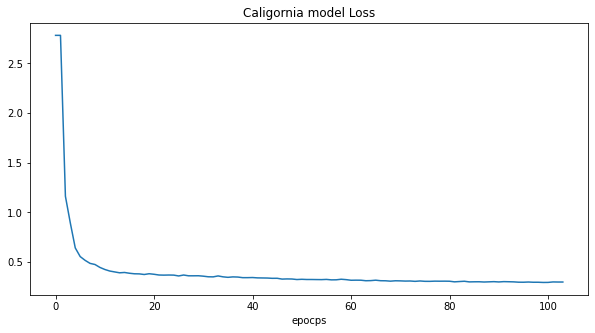

In [36]:
# 손실 함수 그래프
plt.figure(figsize=(10,5))
plt.plot(total_loss)
plt.title("Caligornia model Loss")
plt.xlabel("epocps")
plt.show()

## Pytroch (K-fold)

In [48]:
# 데이터 셋셋
trainset = TensorData(x_train, y_train)
testset = TensorData(x_test, y_test)
testloader = DataLoader(test_set, batch_size=300, shuffle=False)

In [49]:
# madgrad 설치
# 모멘텀텀과 가변식 방법을 병행하는 최신 최적화 방법 (Adam을 능가)
!pip install madgrad
import madgrad

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
# k_fold
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True)
criterion = nn.MSELoss()

In [51]:
# 손실함수 설정정
criterion = nn.MSELoss()

In [57]:
# 교차검증 모델델
validation_loss = []
num_epochs = 300
for fold, (train_idx, val_idx) in enumerate(kfold.split(trainset)):
    # SubsetRandomSampler : 주어진 리스트 내의 인덱스값으로만 (주어진 데이터셋에서) 랜덤하게 뽑겠다. 
    train_subsampler = SubsetRandomSampler(train_idx) # index 생성
    val_subsampler = SubsetRandomSampler(val_idx) # index 생성
    
    # sampler를 이용한 DataLoader 정의
    # sampler : 데이터 인덱스를 다루는 방법, 인덱스를 직접 다루기 때문에 shuffle 파라미터는 반드시 False여야 사용할 수 있음
    trainloader = DataLoader(trainset, batch_size=300, sampler=train_subsampler) 
    valloader = DataLoader(trainset, batch_size=300, sampler=val_subsampler)
    
    # 모델 설정정
    model = Regressor().to(device)
    optimizer = madgrad.MADGRAD(model.parameters(), lr=0.01, momentum = 0.9, weight_decay=1e-7)
    
    for epoch in range(num_epochs):
        for data, targets in train_loader:
            data = data.to(device=device)
            targets = targets.to(device=device)
            scores = model(data)
            loss = criterion(scores, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    train_rmse = evaluation(trainloader)
    val_rmse = evaluation(valloader)
    print("k-fold", fold + 1," Train Loss: %.3f, Validation Loss: %.3f" %(train_rmse, val_rmse)) 
    validation_loss.append(val_rmse)

validation_loss = np.array(validation_loss)
mean = np.mean(validation_loss)
std = np.std(validation_loss)
print("Validation Score: %.3f ± %.3f" %(mean, std))    

k-fold 0  Train Loss: 0.52145, Validation Loss: 0.51730
k-fold 1  Train Loss: 0.52029, Validation Loss: 0.53325
k-fold 2  Train Loss: 0.53749, Validation Loss: 0.52028
k-fold 3  Train Loss: 0.57856, Validation Loss: 0.59292
k-fold 4  Train Loss: 0.53787, Validation Loss: 0.54486
Validation Score: 0.5417, ± 0.0274


In [58]:
# 모델평가가
trainloader = DataLoader(trainset, batch_size=300, shuffle=False)
train_rmse = evaluation(trainloader)
test_rmse = evaluation(testloader) 

print("Train RMSE: %.5f" %train_rmse)
print("Test RMSE: %.5f" %test_rmse)

Train RMSE: 0.53927
Test RMSE: 0.56954


# (번외) 모델 구조 및 가중치 확인

In [59]:
# 모델 호출
model = Regressor()

In [60]:
# 1번 방법 ( __init__ 정의된 구조 출력 )
print(model)

Regressor(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [62]:
# 2번 방법 (named_parameters() 사용)
for name, param in model.named_parameters():
    print(name, param.size())

fc1.weight torch.Size([128, 8])
fc1.bias torch.Size([128])
fc2.weight torch.Size([64, 128])
fc2.bias torch.Size([64])
fc3.weight torch.Size([1, 64])
fc3.bias torch.Size([1])


In [73]:
# 3번 방법 (라이브러리 사용)
from torchsummary import summary
summary(model.to(device), (10, 8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 10, 128]           1,152
            Linear-2               [-1, 10, 64]           8,256
           Dropout-3               [-1, 10, 64]               0
            Linear-4                [-1, 10, 1]              65
Total params: 9,473
Trainable params: 9,473
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.04
Estimated Total Size (MB): 0.06
----------------------------------------------------------------
